In [3]:
import pandas as pd
import numpy as np
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
from IPython import embed

In [23]:
class ProductFamily():
    def __init__(self):
        # インポート
        filepath = './src/design_parameter_table.csv'
        self.df_dp = pd.read_csv(filepath, header=0, index_col=None)
        filepath = './src/product_definition_table.csv'
        self.df_product_definition = pd.read_csv(filepath, header=0, index_col=None)
        filepath = './src/product_model_1.csv'
        self.df_product_model = pd.read_csv(filepath, header=0, index_col=None)

        # numpy化
        self.importances = self.df_product_definition.iloc[:,2:].to_numpy()
        self.sensitivity = self.df_product_model.iloc[:,1:].to_numpy()
        self.dpcp = self.df_dp.loc[:,['design_parameter_id','component_id']].values.tolist()
        self.dpcp = [[int(s[0].replace('Dp', ''))-1, int(s[1].replace('Cp', ''))-1] for s in self.dpcp]

        # 変数定義
        n_pr = len(self.df_product_definition.columns)-2
        n_dp = len(self.df_product_model.columns)-1
        n_fm = len(self.df_product_definition)
        n_cp = len(self.df_dp["component_id"].drop_duplicates())


    def test(self):
        print('a')

pf = ProductFamily()

# インポート

In [4]:
filepath = './src/design_parameter_table.csv'
df_dp = pd.read_csv(filepath, header=0, index_col=None)
filepath = './src/product_definition_table.csv'
df_product_definition = pd.read_csv(filepath, header=0, index_col=None)
filepath = './src/product_model_1.csv'
df_product_model = pd.read_csv(filepath, header=0, index_col=None)
df_product_definition


,functional_metric_id,functional_metric_name,product1,product2,product3,product4
0,Fm1,Maximum speed,9,1,1,1
1,Fm2,Acceleration,9,1,1,1
2,Fm3,Role stability in high speed,5,9,5,5
3,Fm4,Role stability in low speed,5,9,5,5
4,Fm5,Yaw stability in high speed,5,9,5,5
5,Fm6,Yaw stability in low speed,5,9,5,5
6,Fm7,Reachable Distance in low speed,1,1,9,1
7,Fm8,Reachable Distance in high speed,1,1,9,1
8,Fm9,Reachable Distance in low speed (cloudy),1,1,9,1
9,Fm10,Reachable Distance in high speed (cloudy),1,1,9,1


In [5]:
# numpy化
importances = df_product_definition.iloc[:,2:].to_numpy()
sensitivity = df_product_model.iloc[:,1:].to_numpy()
dpcp = df_dp.loc[:,['design_parameter_id','component_id']].values.tolist()
dpcp = [[int(s[0].replace('Dp', ''))-1, int(s[1].replace('Cp', ''))-1] for s in dpcp]

# 変数定義
n_pr = len(df_product_definition.columns)-2
n_dp = len(df_product_model.columns)-1
n_fm = len(df_product_definition)
n_cp = len(df_dp["component_id"].drop_duplicates())

dpcp

[[0, 0],
 [1, 0],
 [2, 0],
 [3, 1],
 [4, 1],
 [5, 1],
 [6, 2],
 [7, 2],
 [8, 2],
 [9, 3],
 [10, 3],
 [11, 3],
 [12, 4],
 [13, 5],
 [14, 5],
 [15, 6],
 [16, 6],
 [17, 7],
 [18, 7],
 [19, 8],
 [20, 8],
 [21, 9],
 [22, 9]]

# 事前算出

## 調整阻害度算出のための$C_p$間の重要度を算出

In [6]:
# Dp間の重要度DSM
dp_dsms = []

for ipr in range(n_pr):
    dp_dsm = []
    for idp1 in range(n_dp-1):
        for idp2 in range(idp1+1, n_dp):
            imp = 0
            for ifm in range(n_fm):
                if sensitivity[ifm,idp1] > 0 and sensitivity[ifm,idp2] > 0:
                    imp += importances[ifm,ipr]
                    # print('dp1:'+str(idp1)+',dp2:'+str(idp2)+',fm:'+str(ifm)+',imp:'+str(importances[ifm,ipr]))
            dp_dsm.append(imp)
    dp_dsms.append(dp_dsm)
# dp_dsms

In [7]:
def comb_index2(idx1, idx2, n2):
    #-----------------------
    # 組み合わせインデックスから組み合わせ番号を返す
    #  idx1/2: 組み合わせインデックス (1~n2)
    #  n2: インデックスの最大値（1~n2)
    #-----------------------

    if idx1 >= idx2 or idx1 < 1 or idx1 > n2 or idx2 < 1 or idx2 > n2:
        print('エラー')

    s = 0
    for i in range(1, idx1):
        s += (n2 - i)
    s += (idx2 - idx1)
    return s

In [8]:
# Cp間の重要度DSM
cp_dsms = []

for ipr in range(n_pr):
    cp_dsm = []
    for icp1 in range(n_cp-1):
        idps1 = [s[0] for s in dpcp if s[1]==icp1]
        for icp2 in range(icp1+1, n_cp):
            idps2 = [s[0] for s in dpcp if s[1]==icp2]

            imp = 0
            for idp1 in idps1:
                for idp2 in idps2:
                    imp += int(dp_dsms[ipr][comb_index2(icp1+1, icp2+1, n_cp)-1])
            cp_dsm.append(imp)
    cp_dsms.append(cp_dsm)
# cp_dsms


## 設計方針ベクトル$\bm{D}_{ij}$の算出

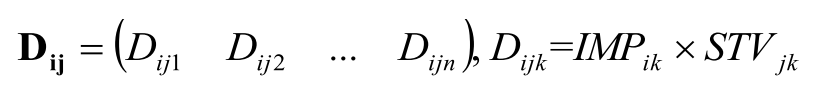

In [9]:
# 設計方針ベクトルの算出
design_policy = np.zeros((n_pr, n_dp, n_fm))

# i:製品，j:設計変数，k:機能尺度
for ipr in range(n_pr):
    for idp in range(n_dp):
        for ifm in range(n_fm):
            design_policy[ipr,idp,ifm] = importances[ifm,ipr] * sensitivity[ifm,idp]
#design_policy

### 設計方針ベクトルの可視化

In [10]:
df0 = pd.DataFrame(data=design_policy[:,3,:],index=['製品1', '製品2', '製品3', '製品4'],columns=["Fm{}".format(x + 1) for x in range(n_fm)])
# import seaborn as sns
# sns.pairplot(df0)

# 主成分分析の実行
pca = PCA(n_components=3)
x = pca.fit_transform(df0.values)   # PCAで次元圧縮
embed3 = pd.DataFrame(x,index=['製品1', '製品2', '製品3', '製品4']) # 可視化のためにデータフレームに変換
embed3["label"] = ['製品1', '製品2', '製品3', '製品4']              
# embed3  # データフレームの先頭を表示

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
embed3.iplot(kind="scatter3d", x=0,y=1,z=2, categories="label")

# 初期化

## 染色体の初期化

In [11]:
def comb_index(n1, n2):
    #-----------------------
    # 組み合わせ番号から2つの組み合わせのインデックスを返す
    #  n1: 組み合わせ番号 (1~)
    #  n2: インデックスの最大値（1~n2)
    #-----------------------

    cnt = 0
    for i in range(n2-1):
        for j in range(i+1, n2):
            cnt += 1
            if cnt == n1:

                return [i+1, j+1]

In [12]:
# 構成部位が共通か個別かを判断する染色体の遺伝子座の長さは，(n_pr)_C_2 * n_cp である．ただし，nは製品数．
chromosome = np.zeros(math.comb(n_pr, 2) * n_cp, dtype=int)

# 遺伝子の初期化ランダム
for i, c in enumerate(chromosome):
    chromosome[i] = random.randrange(2)

for i, c in enumerate(chromosome):
    if c == 1:
        icp = math.floor(float(i) / math.comb(n_pr, 2))+1
        icmb = i % math.comb(n_pr, 2) + 1
        iprs = comb_index(icmb,n_pr)
        print('構成部位' + str(icp) + ', 製品' + str(iprs[0]) + ' x 製品' + str(iprs[1]))

構成部位1, 製品2 x 製品4
構成部位2, 製品1 x 製品2
構成部位2, 製品2 x 製品4
構成部位3, 製品1 x 製品2
構成部位3, 製品3 x 製品4
構成部位4, 製品1 x 製品2
構成部位4, 製品3 x 製品4
構成部位5, 製品1 x 製品4
構成部位5, 製品2 x 製品3
構成部位5, 製品2 x 製品4
構成部位6, 製品1 x 製品3
構成部位6, 製品1 x 製品4
構成部位6, 製品2 x 製品4
構成部位6, 製品3 x 製品4
構成部位7, 製品1 x 製品3
構成部位7, 製品1 x 製品4
構成部位7, 製品2 x 製品3
構成部位7, 製品2 x 製品4
構成部位8, 製品1 x 製品2
構成部位8, 製品1 x 製品4
構成部位9, 製品1 x 製品2
構成部位9, 製品1 x 製品4
構成部位9, 製品2 x 製品3
構成部位9, 製品2 x 製品4
構成部位9, 製品3 x 製品4
構成部位10, 製品1 x 製品2
構成部位10, 製品1 x 製品4
構成部位10, 製品2 x 製品3


In [13]:
#1
chromosome[0]=1 #1x2
chromosome[1]=0 #1x3
chromosome[2]=0 #1x4
chromosome[3]=0 #2x3
chromosome[4]=0 #2x4
chromosome[5]=1 #3x4
#2
chromosome[6]=0 #1x2
chromosome[7]=1 #1x3
chromosome[8]=0 #1x4
chromosome[9]=0 #2x3
chromosome[10]=1 #2x4
chromosome[11]=1 #3x4


## 共通設計変数$D_p$のリスト化

In [15]:

def common_dp_list(chromosome):
    # 共通化される設計変数を格納する
    common_dp = []
    tmp_1 = [] # [構成部位番号, 設計変数番号, [共通化される製品番号(複数)]] <- このリストを作成ための1次元目のリスト

    for i, c in enumerate(chromosome):
        if c == 1:
            icp = math.floor(float(i) / math.comb(n_pr, 2))+1 # 構成部位番号
            icmb = i % math.comb(n_pr, 2) + 1 # 組み合わせ番号（構成部位ごとに繰り返すので）
            iprs = comb_index(icmb,n_pr) # [製品i, 製品j]のリスト
            prs = ['Pr' + str(iprs[0]), 'Pr' + str(iprs[1])]

            # 設計変数のループ
            for dp in df_dp[df_dp.component_id == 'Cp' + str(icp)]['design_parameter_id']:
                # 既配列で，設計変数が同じ，且つ，製品が同じものがあれば，そこに製品番号を追加する
                # なければ，新規に配列を作成して追加する

                # リストの連結役かどうかを判断
                cnt = 0
                save = []
                for j, l1 in enumerate(common_dp):
                    # 他の2要素をつなぐようなprsだったとき，それらのリストを連結する．
                    # common_dp[X] > l1[2][0] == prs[0]
                    # common_dp[Y] > l1[2][0] == prs[1]
                    # となったときは，XとYを連結する必要あり．ただし，両方ともl1[1] == dpのときに限る．
                    if l1[1] == dp:
                        if prs[0] in l1[2] or prs[1] in l1[2]:
                            cnt += 1
                            save.append(j)

                # リストの連結役のとき
                is_comb = True
                if cnt == 2:
                    is_comb = False
                    # 片方のリストを上書きして，もう片方のリストを削除する
                    common_dp[save[0]][2] = list(set(common_dp[save[0]][2] + common_dp[save[1]][2])).copy()
                    del common_dp[save[1]]

                # リストの連結役ではないとき
                if is_comb:
                    is_new = True

                    # 設計変数が同一 且つ 重複する製品番号が存在する場合，そのリストを更新する
                    for j, l1 in enumerate(common_dp):
                        if l1[1] == dp and len(set(prs) & set(l1[2])) != 0:
                            is_new = False
                            # 重複を削除(set)して上書きする
                            l1[2] = list(set(prs + l1[2])).copy()
                            break
                        
                    # 新規作成(追加)する場合の処理
                    if is_new:
                        tmp_1 = []
                        tmp_1.append('Cp' + str(icp)) # 構成部位番号の追加
                        tmp_1.append(dp) # 設計変数の追加
                        tmp_1.append(prs) # 製品組み合わせリストの追加
                        common_dp.append(tmp_1) 
    return common_dp

common_dp = common_dp_list(chromosome)
common_dp

4


[['Cp1', 'Dp1', ['Pr1', 'Pr2']],
 ['Cp1', 'Dp2', ['Pr1', 'Pr2']],
 ['Cp1', 'Dp3', ['Pr1', 'Pr2']],
 ['Cp1', 'Dp1', ['Pr3', 'Pr4']],
 ['Cp1', 'Dp2', ['Pr3', 'Pr4']],
 ['Cp1', 'Dp3', ['Pr3', 'Pr4']],
 ['Cp2', 'Dp4', ['Pr2', 'Pr4', 'Pr1', 'Pr3']],
 ['Cp2', 'Dp5', ['Pr2', 'Pr4', 'Pr1', 'Pr3']],
 ['Cp2', 'Dp6', ['Pr2', 'Pr4', 'Pr1', 'Pr3']],
 ['Cp3', 'Dp7', ['Pr1', 'Pr2']],
 ['Cp3', 'Dp8', ['Pr1', 'Pr2']],
 ['Cp3', 'Dp9', ['Pr1', 'Pr2']],
 ['Cp3', 'Dp7', ['Pr3', 'Pr4']],
 ['Cp3', 'Dp8', ['Pr3', 'Pr4']],
 ['Cp3', 'Dp9', ['Pr3', 'Pr4']],
 ['Cp4', 'Dp10', ['Pr1', 'Pr2']],
 ['Cp4', 'Dp11', ['Pr1', 'Pr2']],
 ['Cp4', 'Dp12', ['Pr1', 'Pr2']],
 ['Cp4', 'Dp10', ['Pr3', 'Pr4']],
 ['Cp4', 'Dp11', ['Pr3', 'Pr4']],
 ['Cp4', 'Dp12', ['Pr3', 'Pr4']],
 ['Cp5', 'Dp13', ['Pr2', 'Pr3', 'Pr1', 'Pr4']],
 ['Cp6', 'Dp14', ['Pr1', 'Pr2', 'Pr3', 'Pr4']],
 ['Cp6', 'Dp15', ['Pr1', 'Pr2', 'Pr3', 'Pr4']],
 ['Cp7', 'Dp16', ['Pr2', 'Pr3', 'Pr1', 'Pr4']],
 ['Cp7', 'Dp17', ['Pr2', 'Pr3', 'Pr1', 'Pr4']],
 ['Cp8', 'Dp18', ['

## 共通構成部位$C_p$のリスト化

In [15]:
# 共通化する構成部位単位でのリストを作成
seen_cp = []
seen_pr = []
common_cp = []
for l in common_dp:
    #1. Cpにないとき，addする
    #2(1). Cpにあるとき，Prになければaddする．
    #2(2). Cpにあるとき，Prが定義されていなければaddする．
    if l[0] not in seen_cp:
        seen_cp.append(l[0])
        seen_pr.append(l[2].copy())
        common_cp.append([l[0], l[2].copy()])
    else:
        if seen_pr == []:
            seen_cp.append(l[0])
            seen_pr.append(l[2].copy())
            common_cp.append([l[0], l[2].copy()])
        else:
            is_exist = False
            for s in seen_pr:
                if set(s) == set(l[2]):
                    is_exist = True
                    break
            if is_exist == False:
                seen_cp.append(l[0])
                seen_pr.append(l[2].copy())
                common_cp.append([l[0], l[2].copy()])
common_cp

[['Cp1', ['Pr1', 'Pr2']],
 ['Cp1', ['Pr3', 'Pr4']],
 ['Cp2', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp3', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp4', ['Pr4', 'Pr2', 'Pr3']],
 ['Cp5', ['Pr4', 'Pr2', 'Pr3']],
 ['Cp6', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp7', ['Pr2', 'Pr4']],
 ['Cp8', ['Pr4', 'Pr3', 'Pr1']],
 ['Cp9', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp10', ['Pr4', 'Pr2', 'Pr3', 'Pr1']]]

## モジュール分割構造のリスト化

In [104]:

def module_list(common_cp, n_pr, n_cp):
    # common_cpから一意にみちびかれるはずである
    mod = []
    
    # 各製品に対して個別かどうかを調査
    for ipr in range(n_pr):
        mod_tmp = []

        # 各構成部位に対して調査
        for icp in range(n_cp):

            # 共通化リストの中にipr製品が存在しないかどうかを確認する
            tmp = [r[0] for r in common_cp]
            idxs = [i for i, x in enumerate(tmp) if x == 'Cp' + str(icp+1)]
            is_no_common = True

            for idx in idxs:
                if 'Pr' + str(ipr+1) in common_cp[idx][1]:
                    is_no_common = False
                    break
        
            if is_no_common == True:
                mod_tmp.append('Cp'+str(icp+1)+',Pr'+str(ipr+1))
        if mod_tmp:
            mod.append(mod_tmp)

    fin = []
    for i1, l1 in enumerate(common_cp):
        if i1 in fin:
            continue

        fin.append(i1)

        mod_tmp = []
        for ll in l1[1]:
            mod_tmp.append(l1[0] + ',' + ll)

        for i2, l2 in enumerate(common_cp):
            if i1 >= i2 or i2 in fin:
                continue

            if set(l1[1]) == set(l2[1]):
                fin.append(i2)
                for ll in l2[1]:
                    mod_tmp.append(l2[0] + ',' + ll)

        mod.append(mod_tmp)
    return(mod)

mod = module_list(common_cp, n_pr, n_cp)

print(sum(len(v) for v in mod))
mod

40


[['Cp4,Pr1', 'Cp5,Pr1', 'Cp7,Pr1'],
 ['Cp8,Pr2'],
 ['Cp7,Pr3'],
 ['Cp1,Pr1', 'Cp1,Pr2'],
 ['Cp1,Pr3', 'Cp1,Pr4'],
 ['Cp2,Pr4',
  'Cp2,Pr2',
  'Cp2,Pr3',
  'Cp2,Pr1',
  'Cp3,Pr4',
  'Cp3,Pr2',
  'Cp3,Pr3',
  'Cp3,Pr1',
  'Cp6,Pr4',
  'Cp6,Pr2',
  'Cp6,Pr3',
  'Cp6,Pr1',
  'Cp9,Pr4',
  'Cp9,Pr2',
  'Cp9,Pr3',
  'Cp9,Pr1',
  'Cp10,Pr4',
  'Cp10,Pr2',
  'Cp10,Pr3',
  'Cp10,Pr1'],
 ['Cp4,Pr4', 'Cp4,Pr2', 'Cp4,Pr3', 'Cp5,Pr4', 'Cp5,Pr2', 'Cp5,Pr3'],
 ['Cp7,Pr2', 'Cp7,Pr4'],
 ['Cp8,Pr4', 'Cp8,Pr3', 'Cp8,Pr1']]

### モジュール分割構造の可視化

      product1  product2  product3  product4
Cp1          3         3         4         4
Cp2          5         5         5         5
Cp3          5         5         5         5
Cp4          0         6         6         6
Cp5          0         6         6         6
Cp6          5         5         5         5
Cp7          0         7         2         7
Cp8          8         1         8         8
Cp9          5         5         5         5
Cp10         5         5         5         5


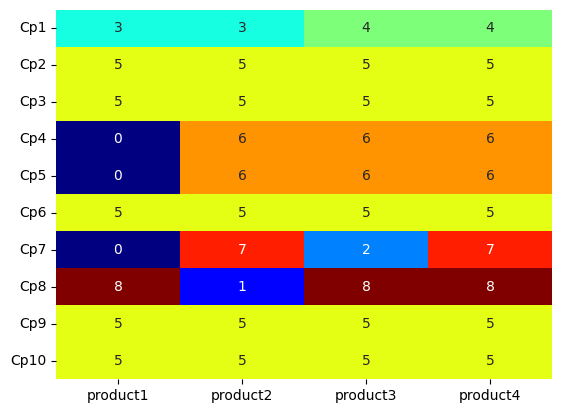

In [102]:
indexs = df_dp["component_id"].drop_duplicates().tolist()
columns = df_product_definition.columns.values.tolist()[2:]

lists = []
for icp in range(len(indexs)):
    l = []
    for ipr in range(len(columns)):
        l.append(0)
    lists.append(l)

for idx, m in enumerate(mod):
    for s in m:
        cp_num = s[:s.find(",")]
        icp = int(cp_num.replace('Cp','')) - 1
        pr_num = s[s.find(",")+1:]
        ipr = int(pr_num.replace('Pr','')) - 1
        lists[icp][ipr] = idx

df_mod = pd.DataFrame(data=lists, index=indexs, columns=columns)
print(df_mod)

%matplotlib inline
plt.figure()
plot_mod = sns.heatmap(df_mod, annot=True, cbar=False, cmap='jet')
plot_mod.set_xticklabels(plot_mod.get_xticklabels(),rotation = 0)
plot_mod.set_yticklabels(plot_mod.get_yticklabels(),rotation = 0)
plt.show(plot_mod)

# 評価

## 総妥協度の算出
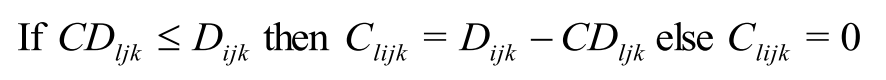

#### $CD_{ljk}$の算出

In [18]:
# 重心ベクトルを算出してcomon_dpに追加
for l in common_dp:
    idp = int(l[1].replace('Dp','')) - 1

    # 共通化される製品番号を抽出する
    iprs_common = [int(s.replace('Pr',''))-1 for s in l[2]]
    icp = int(l[0].replace('Cp',''))-1
    design_policy_center = np.average(design_policy[iprs_common, icp, :], axis=0)
    l.append(design_policy_center)
common_dp

[['Cp1',
  'Dp1',
  ['Pr1', 'Pr2'],
  array([ 5.,  5.,  0.,  0., 21., 21.,  1.,  1.,  1.,  1.,  9.,  9.])],
 ['Cp1',
  'Dp2',
  ['Pr1', 'Pr2'],
  array([ 5.,  5.,  0.,  0., 21., 21.,  1.,  1.,  1.,  1.,  9.,  9.])],
 ['Cp1',
  'Dp3',
  ['Pr1', 'Pr2'],
  array([ 5.,  5.,  0.,  0., 21., 21.,  1.,  1.,  1.,  1.,  9.,  9.])],
 ['Cp1',
  'Dp1',
  ['Pr3', 'Pr4'],
  array([ 1.,  1.,  0.,  0., 15., 15.,  5.,  5.,  5.,  5., 15., 15.])],
 ['Cp1',
  'Dp2',
  ['Pr3', 'Pr4'],
  array([ 1.,  1.,  0.,  0., 15., 15.,  5.,  5.,  5.,  5., 15., 15.])],
 ['Cp1',
  'Dp3',
  ['Pr3', 'Pr4'],
  array([ 1.,  1.,  0.,  0., 15., 15.,  5.,  5.,  5.,  5., 15., 15.])],
 ['Cp2',
  'Dp4',
  ['Pr4', 'Pr2', 'Pr3', 'Pr1'],
  array([9., 3., 6., 6., 6., 6., 3., 3., 3., 3., 0., 0.])],
 ['Cp2',
  'Dp5',
  ['Pr4', 'Pr2', 'Pr3', 'Pr1'],
  array([9., 3., 6., 6., 6., 6., 3., 3., 3., 3., 0., 0.])],
 ['Cp2',
  'Dp6',
  ['Pr4', 'Pr2', 'Pr3', 'Pr1'],
  array([9., 3., 6., 6., 6., 6., 3., 3., 3., 3., 0., 0.])],
 ['Cp3',
  'Dp7',
  ['

### 妥協ベクトル$C_{lijk}$・総妥協度の算出

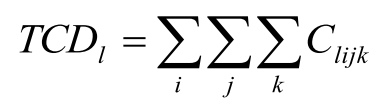

In [19]:
# 妥協ベクトルの算出（1パターン分を格納）
compromise = np.zeros((n_pr, n_dp, n_fm))

# ipr:製品，idp:設計変数，ifm:機能尺度
for idp in range(n_dp):
    for ipr in range(n_pr):

        is_common = False
        for l in common_dp:
            iprs_common = [int(s.replace('Pr','')) - 1 for s in l[2]]

            # 共通化される組み合わせの場合
            if ipr in iprs_common:
                is_common = True
                
                # 機能尺度が，妥協しているもののみ，差分算出する
                for ifm in range(n_fm):
                    if design_policy[ipr,idp,ifm] > l[3][ifm]:
                        compromise[ipr,idp,ifm] = design_policy[ipr,idp,ifm] - l[3][ifm] #たぶんいけるはず？
                    else:
                        compromise[ipr,idp,ifm] = 0
                break

        # 共通化されない組み合わせの場合
        if is_common == False:
            compromise[ipr,idp,:] = 0

total_compromise_degree = np.sum(compromise)
print('総妥協度:' + str(total_compromise_degree))

総妥協度:2210.0


## 部品共通率(PCR)の算出

In [20]:
# 総構成部位数（#CompType）を算出する
# #CompType = \Sigma{icp} [#Pr + 共通化された構成部品"種類"数 - 共通化された構成部品数]
n_comp_type = 0
for icp in range(n_cp):
    n_common_pr_type = 0 # 共通化された構成部品種類数
    n_common_pr = 0 # 共通化された構成部品数
    for l in common_cp:
        if int(l[0].replace('Cp','')) - 1 == icp:
            n_common_pr_type += 1
            n_common_pr += len(l[1])

    # print('共通化された構成部品種類数' + str(n_common_pr_type))
    # print('共通化された構成部品数' + str(n_common_pr))
    n_comp_type += n_pr + n_common_pr_type - n_common_pr
print(n_comp_type)
common_cp

16


[['Cp1', ['Pr1', 'Pr2']],
 ['Cp1', ['Pr3', 'Pr4']],
 ['Cp2', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp3', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp4', ['Pr4', 'Pr2', 'Pr3']],
 ['Cp5', ['Pr4', 'Pr2', 'Pr3']],
 ['Cp6', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp7', ['Pr2', 'Pr4']],
 ['Cp8', ['Pr4', 'Pr3', 'Pr1']],
 ['Cp9', ['Pr4', 'Pr2', 'Pr3', 'Pr1']],
 ['Cp10', ['Pr4', 'Pr2', 'Pr3', 'Pr1']]]

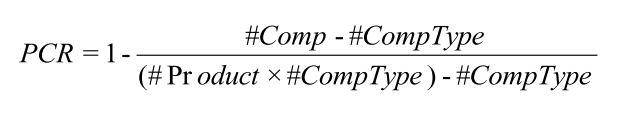

In [21]:
pcr = 1 - (n_cp*n_pr - n_comp_type) / ((n_pr * n_comp_type) - n_comp_type)
print('PCR: ' + str(pcr))

PCR: 0.5


## 構造共通化率(SCR)の算出

In [30]:
cnt = 0
scr = 0

for icp1 in range(n_cp-1):
    for icp2 in range(icp1+1, n_cp):
        for ipr1 in range(n_pr-1):

            # ipr1において，icp1とicp2は同一モジュールか異モジュールか？
            is_mc1 = False
            for l in mod:

                # 同一モジュール内にcp1/2が存在するかどうかを判別する
                is_cp1 = False
                is_cp2 = False
                for s in l:
                    if s == 'Cp' + str(icp1+1) + ',' + 'Pr' + str(ipr1+1):
                        is_cp1 = True
                    if s == 'Cp' + str(icp2+1) + ',' + 'Pr' + str(ipr1+1):
                        is_cp2 = True

                if is_cp1 == True and is_cp2 == True:
                    is_mc1 = True

            for ipr2 in range(ipr1+1, n_pr):

                # ipr2において，icp1とicp2は同一モジュールか異モジュールか？
                is_mc2 = False
                for l in mod:

                    # 同一モジュール内にcp1/2が存在するかどうかを判別する
                    is_cp1 = False
                    is_cp2 = False
                    for s in l:
                        if s == 'Cp' + str(icp1+1) + ',' + 'Pr' + str(ipr2+1):
                            is_cp1 = True
                        if s == 'Cp' + str(icp2+1) + ',' + 'Pr' + str(ipr2+1):
                            is_cp2 = True

                    if is_cp1 == True and is_cp2 == True:
                        is_mc2 = True

                cnt += 1
                # 2製品でともに同一モジュールに含まれる場合か，異モジュールに含まれる場合，+1
                if is_mc1 == is_mc2:
                    scr += 1

scr = scr / cnt
scr

0.9777777777777777

## 調整阻害度の算出

In [36]:
inh_coord = 0

for ipr in range(n_pr):
    for icp1 in range(n_cp-1):
        for icp2 in range(icp1+1, n_cp):

            # iprにおいて，icp1とicp2が異なるモジュールに属するかどうかを判別
            is_same_mod = False
            for l in mod:
                # 同一モジュール内にcp1/2が存在するかどうかを判別する
                is_cp1 = False
                is_cp2 = False
                for s in l:
                    if s == 'Cp' + str(icp1+1) + ',' + 'Pr' + str(ipr1+1):
                        is_cp1 = True
                    if s == 'Cp' + str(icp2+1) + ',' + 'Pr' + str(ipr1+1):
                        is_cp2 = True

                if is_cp1 == True and is_cp2 == True:
                    is_same_mod = True
            # iprにおいて，icp1とicp2が異なるモジュールに属する場合
            if is_same_mod == False:
                inh_coord += cp_dsms[ipr][comb_index2(icp1+1, icp2+1, n_cp) - 1]

    print('pr'+str(ipr+1)+': '+str(inh_coord))
inh_coord

pr1: 4839
pr2: 8578
pr3: 14777
pr4: 17832


17832